# Inversion of a Chest X-ray

This short notebook showcases on how to use the encoder to invert an x-ray into latent space.
Additionally, we apply iterative optimization to enhance the inverted sample.

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import torch
from torchvision.transforms.functional import to_tensor

from src.losses.e4eloss import E4ELoss
from src.iterative import IterativeOptimizer
from src.model.encoder import ConvNextEncoder
from src.model.pgan import make_generator

device = torch.device('cpu')

### Load image

Our example is a synthetic chest x-ray - generated by a diffusion model.

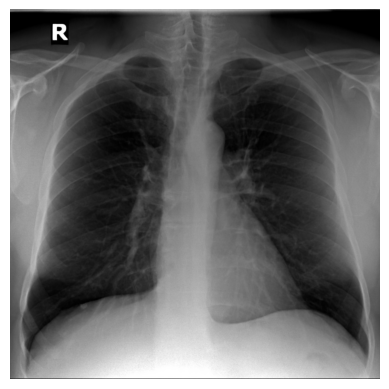

In [33]:
img_path = '../assets/example_scan_synthetic.png'
img = to_tensor(Image.open(img_path).convert('RGB')).to(device)

plt.imshow(img.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.show()

## Load Encoder & Generator

In [34]:
enc_path = '../models/convnext_fine.pt'
gen_path = '../models/chexgan_generator.pt'

encoder = ConvNextEncoder(
    z_dim=512, in_size=1024, convnext_type='convnext_small'
).to(device)
enc_state_dict = torch.load(enc_path, map_location=device)['model']
enc_state_dict = {key.replace('module.', ''): val for key, val in
                  enc_state_dict.items()}
encoder.load_state_dict(enc_state_dict)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

generator = make_generator(gen_path, map_location=device)
generator.eval()
for p in generator.parameters():
    p.requires_grad = False

Generator Weights Loaded


### Inversion

We use the encoder to get the matching point in latent space and
check how well cycle consistency is enforced using the generator.

In [35]:
z_hat = encoder(img.unsqueeze(0))
img_rec = generator(z_hat)

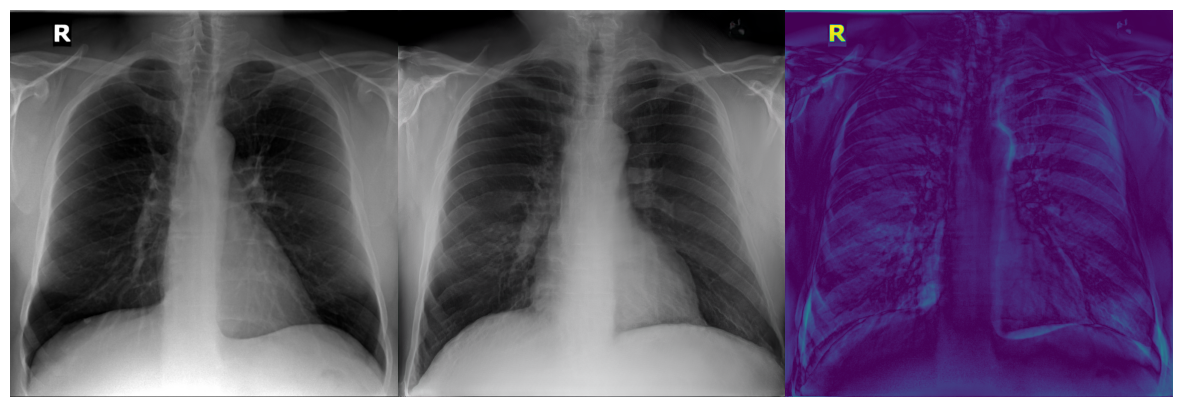

In [36]:
img_rec = img_rec.squeeze(0)
img_rec.clamp_(0, 1)

# Compute residuals from original image
residual = torch.mean(torch.abs(img - img_rec), dim=0)

fig = plt.figure(figsize=(15, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, )

grid[0].imshow(img.permute(1, 2, 0).cpu().numpy())
grid[1].imshow(img_rec.permute(1, 2, 0).cpu().numpy())
grid[2].imshow(residual.cpu().numpy())

for ax in grid:
    ax.axis('off')

plt.show()
plt.close()

### Iterative Optimization

To save memory and compute, use the `MSELoss` only.

In [37]:
#loss_func = E4ELoss(moco_path='../models/mocov2.pt').to(device)
loss_func = torch.nn.MSELoss()

iter_opt = IterativeOptimizer(
    generator=generator.cuda(),
    loss_func=loss_func,
    steps=1000
)

z_opt, img_opt = iter_opt.run(z_hat.cuda(), img.unsqueeze(0).cuda())

Loss: 0.0036: 100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


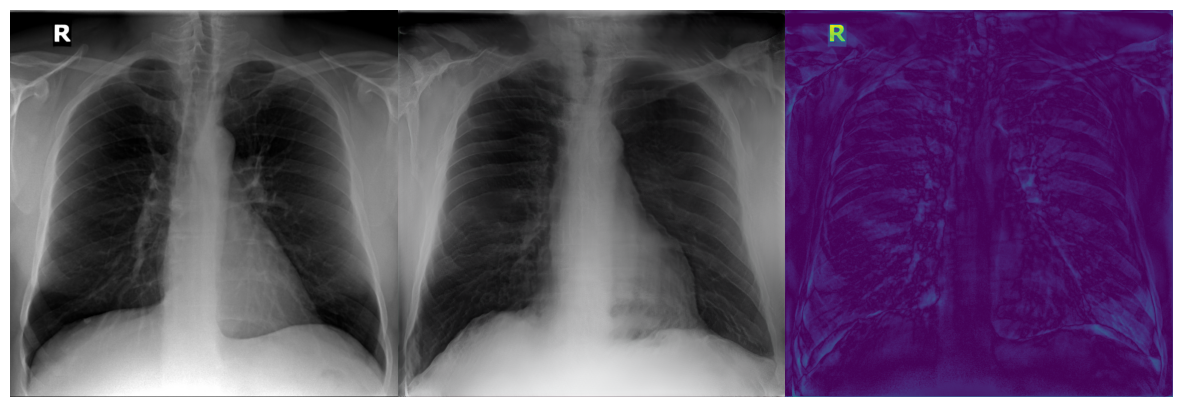

In [38]:
img_opt = img_opt.squeeze(0).cpu()
img_opt.clamp_(0, 1)

# Compute residuals from original image
residual = torch.mean(torch.abs(img - img_opt), dim=0)

fig = plt.figure(figsize=(15, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, )

grid[0].imshow(img.permute(1, 2, 0).cpu().numpy())
grid[1].imshow(img_opt.permute(1, 2, 0).detach().cpu().numpy())
grid[2].imshow(residual.cpu().detach().numpy())

for ax in grid:
    ax.axis('off')

plt.show()
plt.close()